# Nicholas Colonna
## Homework 3
### "I pledge my honor that I have abided by the Stevens Honor System." -Nicholas Colonna

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statistics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv("./Weekly.csv")
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


1. Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

You can observe through some numerical summaries that there are typically more 'Up' weeks than 'Down.' Therefore, you can see that the average weekly return is positive, although small.

You can observe from the data that returns generally stay close to 0, but generally fluctuate between 5% and -5%. However, you can see that during years that there are recessions, the weekly returns become much more extreme in both directions, spanning form -20% to 15%.

You can also observe that volume has increased significantly since 1990. This can be attributed to the rise of technology and electronic trading.

Average Volume: 1.5746176255280073
Average Return: 0.1498989898989899

Number of Up Weeks: 605 (55.56%)
Number of Down Weeks: 484 (44.44%)



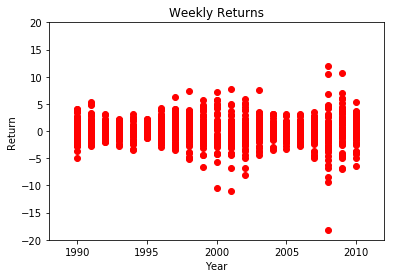

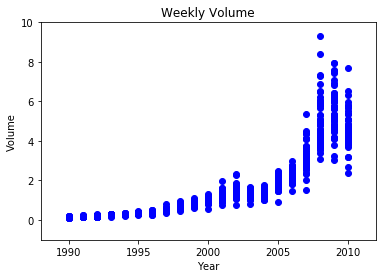

In [2]:
print("Average Volume:", statistics.mean(df['Volume']))
print("Average Return:", statistics.mean(df['Today']))
print()

num_up = 0
num_down = 0
for direction in df['Direction']:
    if direction=='Up':
        num_up+=1
    else:
        num_down+=1
print("Number of Up Weeks: ",num_up," (",round(100*num_up/(num_up+num_down),2),"%)", sep='')
print("Number of Down Weeks: ",num_down," (",round(100*num_down/(num_up+num_down),2),"%)", sep='')
print()

plt.figure()
plt.plot(df['Year'], df['Today'], 'ro')
plt.axis([1988, 2012, -20, 20])
plt.xlabel('Year')
plt.ylabel('Return')
plt.title('Weekly Returns')
plt.show()

plt.figure()
plt.plot(df['Year'], df['Volume'], 'bo')
plt.axis([1988, 2012, -1, 10])
plt.xlabel('Year')
plt.ylabel('Volume')
plt.title('Weekly Volume')
plt.show()

2. Use the full data set to perform a logistic regression (baseline algorithm) with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

First, I created a new column 'Direction_ind' which assigned the value 1 if the variable 'Direction' was equal to "Up" and 0 if it was "Down." This will allow us to run our regression.

After running the regression, it is apparent that the variables Lag2 and Volume are statistically significant (p-value < 0.05).

In [3]:
df['Direction_ind'] = (df['Direction'] == "Up").astype(int)

y = df['Direction_ind']
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]

logistic_reg = sm.Logit(y, X).fit()
print(logistic_reg.summary())

Optimization terminated successfully.
         Current function value: 0.686896
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction_ind   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1083
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Oct 2018   Pseudo R-squ.:               9.505e-05
Time:                        15:48:08   Log-Likelihood:                -748.03
converged:                       True   LL-Null:                       -748.10
                                        LLR p-value:                    0.9996
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag1          -0.0327      0.026     -1.250      0.211      -0.084       0.019
Lag2           0.0682      0.

3. Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

As you can see from the confusion matrix, there are 172 data points where the model correctly predicted Down. There were also 427 times when the model correctly predicted Up. However, you will notice that there were 312 times when the model falsely identified Up when the true data was Down, and also 178 times when the model falsely identified Down when the true data was Up. With the large amount of misclassification, it leads me to believe that this model does a poor job of differentiating points that are close to zero.

In [4]:
direct_predict = logistic_reg.predict()
predict_classify = ["Up" if x>0.5 else "Down" for x in direct_predict]
conf_all = pd.DataFrame(confusion_matrix(df['Direction'], predict_classify))
conf_all = conf_all.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_all)
print()
print(classification_report(df['Direction'], predict_classify, digits=4))

             Predicted Down  Predicted Up
Actual Down             172           312
Actual Up               178           427

             precision    recall  f1-score   support

       Down     0.4914    0.3554    0.4125       484
         Up     0.5778    0.7058    0.6354       605

avg / total     0.5394    0.5500    0.5363      1089



4. Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

We observe that the p-value for Lag2 is significant at predicting the Direction of our returns from 1990 to 2008. Once we apply that model to our test data, from 2009 to 2010, we were able to see how well our model is at predicting. The model correctly classified 57 data points and falsely classified 47. Again, this model isn't great at predicting points close to zero.

In [5]:
trained_logit = sm.Logit(df[:-104]['Direction_ind'], df[:-104]['Lag2']).fit()
print(trained_logit.summary())
print()

logit_predict = trained_logit.predict(df[-104:]['Lag2'])
logit_predict_classify = ["Up" if x>0.5 else "Down" for x in logit_predict]
conf_logit = pd.DataFrame(confusion_matrix(df[-104:]['Direction'], logit_predict_classify))
conf_logit = conf_logit.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_logit)
print()
print(classification_report(df[-104:]['Direction'], logit_predict_classify, digits=4))

Optimization terminated successfully.
         Current function value: 0.690654
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction_ind   No. Observations:                  985
Model:                          Logit   Df Residuals:                      984
Method:                           MLE   Df Model:                            0
Date:                Tue, 09 Oct 2018   Pseudo R-squ.:               -0.004340
Time:                        15:48:12   Log-Likelihood:                -680.29
converged:                       True   LL-Null:                       -677.35
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag2           0.0629      0.029      2.192      0.028       0.007       0.119

             Predicted Down 

5. Repeat (d) using linear discriminant analysis (LDA). This method uses the Bayes classifier with a Gaussian distribution. Even though the discriminant functions are linear functions of the inputs (x), the combination of several classifiers may lead to classification of non-linear problems.

After generating a confusion matrix for our LDA, we obtained interesting results. The model correctly classified 9 Down data points and 56 Up points, however, it misclassified 34 Down data points as Up and 5 Up data points as Down. It appears that the LDA model classified a majority of our data as Up, which led to a lot of misclassification and a low recall score for down. However, this model correctly predicted 65 directions in comparison to the logistic model's 57, and had a higher avg/total precision, recall and f1-score, therefore it may be a better model.

In [6]:
trained_lag2 = np.array(df[:-104]['Lag2'])
out_lag2 = np.array(df[-104:]['Lag2'])
trained_lda = LinearDiscriminantAnalysis().fit(trained_lag2.reshape(-1,1), df[:-104]['Direction_ind'])

lda_predict = trained_lda.predict(out_lag2.reshape(-1,1))
lda_predict_classify = ["Up" if x>0.5 else "Down" for x in lda_predict]
conf_lda = pd.DataFrame(confusion_matrix(df[-104:]['Direction'], lda_predict_classify))
conf_lda = conf_lda.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_lda)
print()

print(classification_report(df[-104:]['Direction'], lda_predict_classify, digits=4))

             Predicted Down  Predicted Up
Actual Down               9            34
Actual Up                 5            56

             precision    recall  f1-score   support

       Down     0.6429    0.2093    0.3158        43
         Up     0.6222    0.9180    0.7417        61

avg / total     0.6308    0.6250    0.5656       104



6. Repeat (d) using quadratic discriminant analysis (QDA)

The QDA model predicted that all of our future data points would be Up, and therefore accurately predicted 61 data points, but misclassified all 43 down points. For these reasons, we see a very low precision score and low f1-score. Although this model accurately predicted 61 points, since it only predicts up as our future values, it will not be a good model to use.

In [7]:
trained_qda = QuadraticDiscriminantAnalysis().fit(trained_lag2.reshape(-1,1), df[:-104]['Direction_ind'])

qda_predict = trained_qda.predict(out_lag2.reshape(-1,1))
qda_predict_classify = ["Up" if x>0.5 else "Down" for x in qda_predict]
conf_qda = pd.DataFrame(confusion_matrix(df[-104:]['Direction'], qda_predict_classify))
conf_qda = conf_qda.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_qda)
print()
print(classification_report(df[-104:]['Direction'], qda_predict_classify, digits=4))

             Predicted Down  Predicted Up
Actual Down               0            43
Actual Up                 0            61

             precision    recall  f1-score   support

       Down     0.0000    0.0000    0.0000        43
         Up     0.5865    1.0000    0.7394        61

avg / total     0.3440    0.5865    0.4337       104



C:\Users\colon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


7. Repeat (d) using K-NN with K = 1.

Our KNN model accurately predicted 21 Down points and 30 Up points, however, it misclassified 22 Down points as Up and 31 Up points as Down. This means the model was able to accurately predict just below 50% of our data points. This leads to a total precision, recall and f1-score around 0.5. Since these numbers are less than those of the logistic and LDA model, I would not choose the KNN model.

In [8]:
trained_knn = KNeighborsClassifier(n_neighbors=1).fit(trained_lag2.reshape(-1,1), df[:-104]['Direction_ind'])

knn_predict = trained_knn.predict(out_lag2.reshape(-1,1))
knn_predict_classify = ["Up" if x>0.5 else "Down" for x in knn_predict]
conf_knn = pd.DataFrame(confusion_matrix(df[-104:]['Direction'], knn_predict_classify))
conf_knn = conf_knn.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_knn)
print()
print(classification_report(df[-104:]['Direction'], knn_predict_classify, digits=4))

             Predicted Down  Predicted Up
Actual Down              21            22
Actual Up                31            30

             precision    recall  f1-score   support

       Down     0.4038    0.4884    0.4421        43
         Up     0.5769    0.4918    0.5310        61

avg / total     0.5054    0.4904    0.4942       104



8. Which of these methods appears to provide the best results on this data?

The model with the highest avg / total for f1-score will be the one that produces the best results. After comparing all of the models, it is clear that the LDA was the best, with an f1-score of 0.5656. This means the model does decent with prediction while also having decent recall. The second best model results were from the logistical regression.

9. Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the K-NN classifier.

After playing around with the various methods and variables, I arrived at 3 improved models from their original form. First, I was able to improve the logistical model by using the 3 variables Lag1, Lag2, and Lag3. This yielded a better confusion matrix and a total f1-score of 0.5699.

I was able to improve the LDA model by adding the variables Lag3 and Volume to the original model of Lag2. With these new variables, the confusion matrix improved and we got a better f1-score of 0.5704. This model is better than the original LDA.

Lastly, I was able to improve the KNN model and I got the best results out of all models. I used K=100 and I added the variables Lag1 and Lag3 to the orignal predictors of just Lag2. As a result, there were 63 correctly classified data points and only 41 misclassified. This yielded strong prediction and recall numbers and an improved f1-score of 0.5963.

In [9]:
x2 = ['Lag1', 'Lag2', 'Lag3',]
trained_logit2 = sm.Logit(df[:-104]['Direction_ind'], df[:-104][x2]).fit()

logit_predict2 = trained_logit2.predict(df[-104:][x2])
logit_predict2_classify = ["Up" if x>0.5 else "Down" for x in logit_predict2]
conf_logit2 = pd.DataFrame(confusion_matrix(df[-104:]['Direction'], logit_predict2_classify))
conf_logit2 = conf_logit2.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_logit2)
print()
print(classification_report(df[-104:]['Direction'], logit_predict2_classify, digits=4))
print()
print()


x3 = ['Lag2', 'Lag3', 'Volume']
trained_lda2 = LinearDiscriminantAnalysis().fit(df[:-104][x3], df[:-104]['Direction_ind'])

lda_predict2 = trained_lda2.predict(df[-104:][x3])
lda_predict2_classify = ["Up" if x>0.5 else "Down" for x in lda_predict2]
conf_lda2 = pd.DataFrame(confusion_matrix(df[-104:]['Direction'], lda_predict2_classify))
conf_lda2 = conf_lda2.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_lda2)
print()
print(classification_report(df[-104:]['Direction'], lda_predict2_classify, digits=4))
print()
print()


x4 = ['Lag1','Lag2','Lag3']
trained_knn2 = KNeighborsClassifier(n_neighbors=100).fit(df[:-104][x4], df[:-104]['Direction_ind'])

knn_predict2 = trained_knn2.predict(df[-104:][x4])
knn_predict2_classify = ["Up" if x>0.5 else "Down" for x in knn_predict2]
conf_knn2 = pd.DataFrame(confusion_matrix(df[-104:]['Direction'], knn_predict2_classify))
conf_knn2 = conf_knn2.rename(index={0:'Actual Down', 1:'Actual Up'}, columns={0:'Predicted Down', 1:'Predicted Up'})
print(conf_knn2)
print()
print(classification_report(df[-104:]['Direction'], knn_predict2_classify, digits=4))

Optimization terminated successfully.
         Current function value: 0.689186
         Iterations 4
             Predicted Down  Predicted Up
Actual Down              23            20
Actual Up                25            36

             precision    recall  f1-score   support

       Down     0.4792    0.5349    0.5055        43
         Up     0.6429    0.5902    0.6154        61

avg / total     0.5752    0.5673    0.5699       104



             Predicted Down  Predicted Up
Actual Down              24            19
Actual Up                26            35

             precision    recall  f1-score   support

       Down     0.4800    0.5581    0.5161        43
         Up     0.6481    0.5738    0.6087        61

avg / total     0.5786    0.5673    0.5704       104



             Predicted Down  Predicted Up
Actual Down              18            25
Actual Up                16            45

             precision    recall  f1-score   support

       Down     0.5294    0.4